## Uncomment & Run the below cell if you're using Colab

In [1]:
# !git clone https://github.com/mayahq/g-index-benchmark
# %cd /content/g-index-benchmark/notebooks/

fatal: destination path 'g-index-benchmark' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/g-index-benchmark/notebooks/'
/home/atlas/dagbert-code/g-index-benchmark/notebooks


## Imports

In [2]:
import glob
import json
import os
import sys
from collections import defaultdict
from os import PathLike
from pprint import pprint
from statistics import mean
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import ipywidgets as widgets
from ipywidgets import Dropdown, FloatLogSlider, FloatSlider, IntSlider, interact

from g_index import Experiment
from node_utils import node_divergence
from utils import *

# Experiment Settings
EXP_ROOT = "../experiments/"
EXP_FILES = glob.glob(EXP_ROOT + "/*.json")
DD_CACHE = cache_dd()
DOMAIN_LENGTHS = get_domain_lengths(AVAILABLE_DOMAINS)

##Plot Settings
ALPHA, S = 0.90, 240
FIGSIZE = (16,9)
LABEL_SIZE = 24
TICK_SIZE = 20
TITLE_SIZE = 24
LEGEND_SIZE = 20

colors = ["#375E97", "#FB6542", "#FFBB00", "#3F681C"]
sim_colors = ["#C03221", "#A049AB", "#3C28B8", "#545E75", "#3F826D"]
models = ["gpt2-774M", "gpt2-345M", "gpt2-1.5B", "gptneo-2.7B"]
model_colormap = {model: color for color, model in zip(colors, models)}
model_name_correction = {
    "gpt2-medium": "gpt2-345M",
    "gpt2-large": "gpt2-774M",
    "gpt2-xl": "gpt2-1.5B",
    "EleutherAI gpt-neo-2.7B": "gptneo-2.7B",
}

## 1. Domains

### What are domains

A set of tasks \$C$ can be clustered into `Task Domains`. <br>
Tasks within the same domain are <i>closer</i> to each other than tasks in different domains.

### List of Available Domains

In [3]:
for i, domain in enumerate(AVAILABLE_DOMAINS):
    print(i, " ", domain)

0   template-slider
1   template-form
2   url-skill
3   cron-schedule
4   gmail-send
5   telegram-3-reply
6   telegram-2-reply
7   youtube-pause
8   youtube-resume
9   http
10   cron-reminder
11   google-search
12   twitter
13   youtube-play
14   facebook
15   googlesearch-to-csv


### What is Domain Distance ( $\Omega$ )

Domain Distance of a Task $T'$ from a set of tasks $C$ is the 
similarity between optimal DAG program for $T'$ and it's nearest neighbour in $C$.

\begin{equation}
	\label{domain-distcalc}
	\begin{aligned}
		 \Omega(T', C) & = \min\limits_{T \in C} \Delta(G_{P'_{opt}}, G_{P_T})                                          &   & \\
		              & \text{where }  G_{P'_{opt}} \text{denotes the DAG of the optimal solution $P'_{opt}$ of $T'$} &   & \\
		              & \text{and }    G_{P'_T} \text{ denotes the DAG for a program $P_T$ that solves
		 $T \in C$}    &                                                                                                &
	\end{aligned}
\end{equation}

Domain distance can be calculated for a set of tasks $T'$ by averaging over all tasks.

### Calculating domain distance between two domains

Domain distance can be calculated between any two domains in `AVAILABLE_DOMAINS`

In [4]:
domain_1 = Dropdown(options=AVAILABLE_DOMAINS, description="Domain 1")
domain_2 = Dropdown(options=AVAILABLE_DOMAINS, description="Domain 2")

@interact(domain_1=domain_1, domain_2=domain_2)
def get_dd_i(domain_1, domain_2):
    print(calculate_dd(domain_1, domain_2))

interactive(children=(Dropdown(description='Domain 1', options=('template-slider', 'template-form', 'url-skill…

### Calculating Domain Distance between two JSON files

Treating each file as it's own domain with a single sample Domain Distance can be calculated between two domain files.

In [5]:
domain_1 = widgets.Text(
    value="../domains/youtube-pause/youtube-pause-6e696d.json",
    placeholder="Enter Relative File Path",
    description="Domain 1 :",
    disabled=False,
)
domain_2 = widgets.Text(
    value="../domains/facebook/facebook-b4ee9a.json",
    placeholder="Enter Relative File Path ",
    description="Domain 2 :",
    disabled=False,
)


@interact(domain_1=domain_1, domain_2=domain_2)
def get_dd_files_i(domain_1, domain_2):
    dd = calculate_dd(domain_1, domain_2)
    if dd is not None:
        print(f"DD: {dd}")

interactive(children=(Text(value='../domains/youtube-pause/youtube-pause-6e696d.json', description='Domain 1 :…

### Plotting the Domain Distance Matrix

Domain Distance between various domain can easily be visualised with the following heatmap.


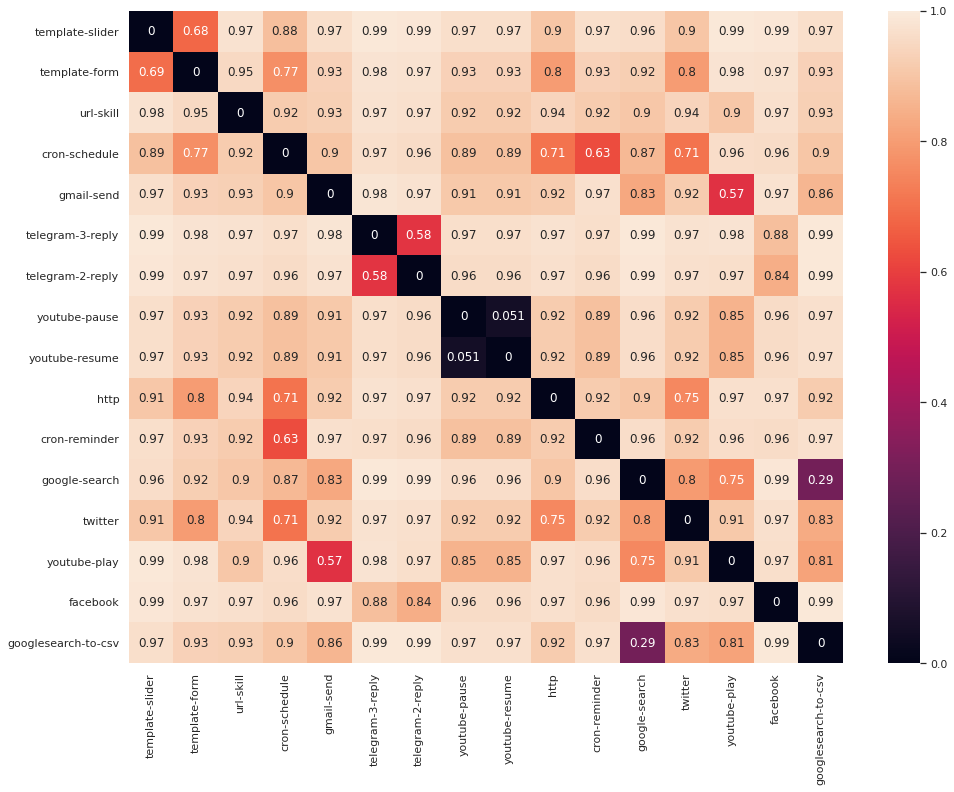

In [6]:
sns.set(rc={"figure.figsize": (16, 12)})
generate_dd_matrix()

## 2. Experiments

### Components of an experiment

The Major Components of an experiment are:
1. Intelligent System (`IS`)
2. Curricula Domains ($C$) 
3. Task Domains ($\{T'\}$)
4. Experience (`E`) 
5. Generalization Difficulty (GD)
6. Performance Details
7. AveragePerformance ($\theta$)

Note: Uncheck `truncate_domains` to view full domain data

In [7]:
experiments = Dropdown(options=EXP_FILES, description="Experiments")
@interact(exp_file=experiments,truncate_domains=True)
def print_exp_components_i(exp_file, truncate_domains=False):
    exp = Experiment(exp_file)
    exp.get_exp_components(truncate_domains=truncate_domains, print_members=True)

interactive(children=(Dropdown(description='Experiments', options=('../experiments/GPT2_1_5B_2.json', '../expe…

## 3. g-index

### What is `g-index`?

<em>`g-index`</em> is used to measure skill-acquisition efficiency of any intelligence system on a set of real-world tasks.

![g-index](../images/gindex.png)

### Calculating `g-index` from an experiment files

Steps:
1. Select an Experiment file in the Experiment Class
2. Run `calculate_g_index` function

In [8]:
experiments = Dropdown(options=EXP_FILES, description="Experiments")
@interact(exp_file=experiments)
def get_g_index_i(exp_file):
    exp = Experiment(exp_file)
    print(f"g-index: {exp.calculate_g_index()}")

interactive(children=(Dropdown(description='Experiments', options=('../experiments/GPT2_1_5B_2.json', '../expe…

### Calculating `g-index` from Values

In [9]:
style = {"description_width": "100px"}
n_tasks_domain = IntSlider(value=5,min=1,max=100,step=1,description="Samples per Task domain",style=style)
n_curricula_domain = IntSlider(value=5,min=1,max=100,step=1,description="Samples per Curricula domain",style=style)
sim_dd = FloatSlider(value=0.0,min=0.0,max=1.00,step=0.01,description="Generalization Difficulty",style=style)
sim_P = FloatLogSlider(value=-3, min=-10, max=10, step=1, description="Prior", style=style)
sim_E = FloatLogSlider(value=1, min=1, max=12, step=1, description="Experience", style=style)
sim_PTheta = FloatSlider(value=0.1,min=0.00,max=1.00,step=0.01,description="Performance θ",style=style)


@interact(n_tasks_domain= n_tasks_domain,n_curricula_domain = n_curricula_domain,sim_dd = sim_dd,sim_P= sim_P,sim_E = sim_E,sim_PTheta = sim_PTheta)
def get_g_index_sim_i(n_tasks_domain,n_curricula_domain,sim_dd,sim_P,sim_E,sim_PTheta):
    exp = Experiment()
    g_index =  exp.simulate_g_index(n_tasks_domain= n_tasks_domain,n_curricula_domain = n_curricula_domain,sim_dd = sim_dd,sim_P= sim_P,sim_E = sim_E,sim_PTheta = sim_PTheta)
    print(f"g-index: {g_index}")

interactive(children=(IntSlider(value=5, description='Samples per Task domain', min=1, style=SliderStyle(descr…

## 4. Reproducing results mentioned in the paper

## Disclaimer


The experiments data & the domain samples provided are a small fraction of the data used during the research. 
Due to this, your results might vary from the reported results. <br>
Interested people can go to the section 5 to get more info.

### Section-4.1 Simulation Plots

#### g-index vs Training Samples ( for varying $\theta$ ) 

<big> Setting up the following Simulation variables</big>

1. Number of samples per curricula domain (Varying) 
2. Average performance (Varying) 
3. Number of samples per task domain (Fixed) 
4. Iterations per domain  
5. Raw experience (compute) 
6. Priors

In [10]:
ns_curricula_domain = [ 20 * i for i in range(1, 33)]# No of Samples per domain from 20 to 640
sim_PthetaValues = np.around( np.arange(0.2, 1.2, 0.2), 2).tolist()  # Average Performance Values from 0.2 to 1.0
num_domains = len(AVAILABLE_DOMAINS)
n_tasks_domain = 5
iters_per_domain = 20
sim_E = 1e2
sim_P = 1e-3
sim_dd = None 
dd_cache = cache_dd() # To speed up the simulations by using precalculated domain distances across domains.

In [11]:
results_gt = defaultdict(dict) 
for sim_Ptheta in tqdm(sim_PthetaValues):
    dummy_exp = Experiment(dd_cache=dd_cache) # Setup a dummy experiment to simulate values
    ns_gi = {"samples_per_domain": [], "g_index": []}
    for ns_per_domain in ns_curricula_domain:
        for _ in range(iters_per_domain):
            # Randomly distribute samples across domains
            CurriculaDistribution = dict(zip(AVAILABLE_DOMAINS, resplit(ns_per_domain, num_domains)))
            # Get the value of g-index from simulations 
            g_index = dummy_exp.simulate_g_index(n_tasks_domain=n_tasks_domain,sim_P=sim_P,sim_E=sim_E,sim_PTheta=sim_Ptheta,
                                                 CurriculaDistribution=CurriculaDistribution,sim_dd=sim_dd)
            ns_gi["samples_per_domain"].append(ns_per_domain)
            ns_gi["g_index"].append(g_index)
    results_gt[sim_Ptheta] = ns_gi

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.25s/it]


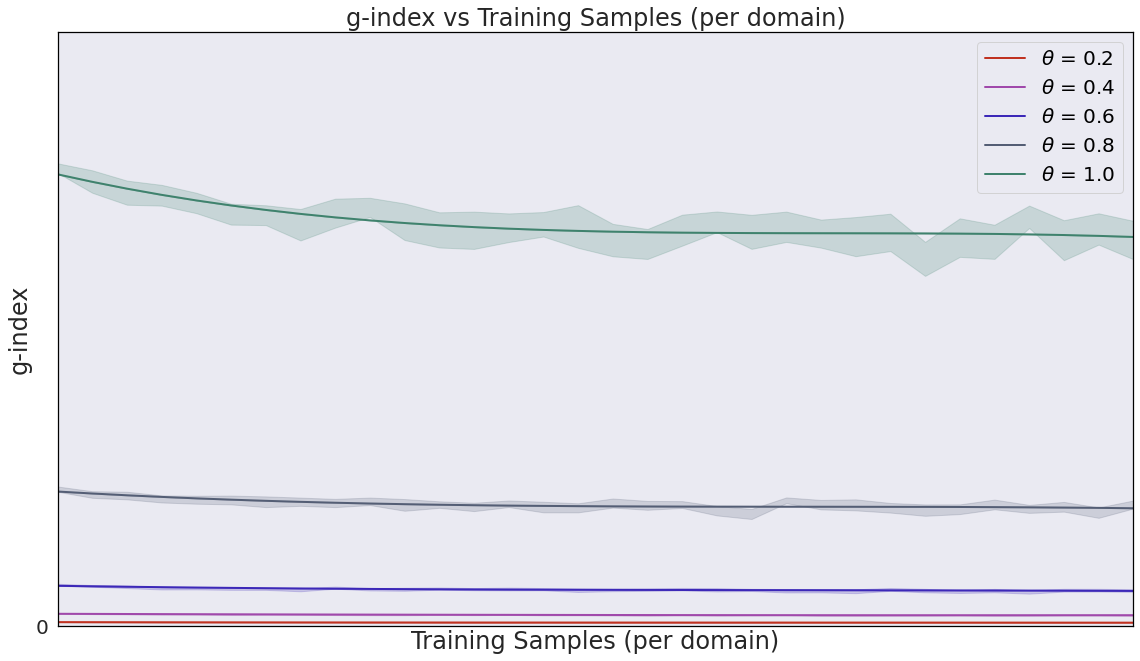

In [12]:
fig, axes = plt.subplots(figsize=FIGSIZE)
xlabel = "Training Samples (per domain)"
ylabel = "g-index"
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.xlim(20, 640)
plt.ylim(0,13000)
set_axes() # Fix axes spines & ticks, see utils.py for more details

for idx, sim_Ptheta in enumerate(results_gt.keys()):
    vals = results_gt[sim_Ptheta]
    x = vals["samples_per_domain"]
    y = vals["g_index"]
    # Curve Smoothing with 3 degree polynomial
    fx = np.poly1d(np.polyfit(np.array(x), np.array(y), 3))
    z = fx(x)
    # Plot the confidence interval
    sns.lineplot(x=x, y=y, ax=axes, legend=False,linewidth=0, color=sim_colors[idx])
    # Plot against the smoothed value
    sns.lineplot(x=x,y=z,ax=axes,legend=False,linewidth=2,label=f"$\\theta$ = {sim_Ptheta}",color=sim_colors[idx])
plt.legend(loc="upper right", labelcolor="black",fontsize=LEGEND_SIZE)
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}", loc="center", fontsize=TITLE_SIZE)
plt.show()

#### g-index vs Compute ( for varying $\theta$ ) 

<big> Setting up the following Simulation variables</big>

1. Compute steps (varying)
2. Average performance (varying)
3. Number of samples per curricula domain (fixed)
4. Number of samples  per task domain (fixed)
5. Iterations per domain (fixed) 
6. Priors (fixed)

In [13]:
sim_compute_steps = [50 * i for i in range(1, 31)] # Compute from 50-1500
sim_PthetaValues = np.around(np.arange(0.2, 1.2, 0.2), 2).tolist()  # Average Performance Values from 0.2 to 1.0
n_samples_per_domain = 40
n_tasks_domain = 5
num_domains = len(AVAILABLE_DOMAINS)
sim_P = 1e-2
iters_per_compute_step = 5
dd_cache = cache_dd()
sim_dd = None

In [14]:
results_gcp = defaultdict(dict)

for sim_Ptheta in tqdm(sim_PthetaValues):
    dummy_exp = Experiment(dd_cache=dd_cache) # Setup a dummy experiment to simulate values
    gi = {"compute": [], "g_index": []}
    for sim_E in sim_compute_steps:
        for itp in range(iters_per_compute_step):
            
            CurriculaDistribution = dict(zip(AVAILABLE_DOMAINS, resplit(n_samples_per_domain, num_domains)))
            g_index = dummy_exp.simulate_g_index(
                n_tasks_domain=n_tasks_domain,
                sim_P=sim_P,
                sim_E=sim_E,
                sim_PTheta=sim_Ptheta,
                CurriculaDistribution=CurriculaDistribution,
                sim_dd=sim_dd)
            gi["compute"].append(sim_E)
            gi["g_index"].append(g_index)

    results_gcp[sim_Ptheta] = gi

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.21s/it]


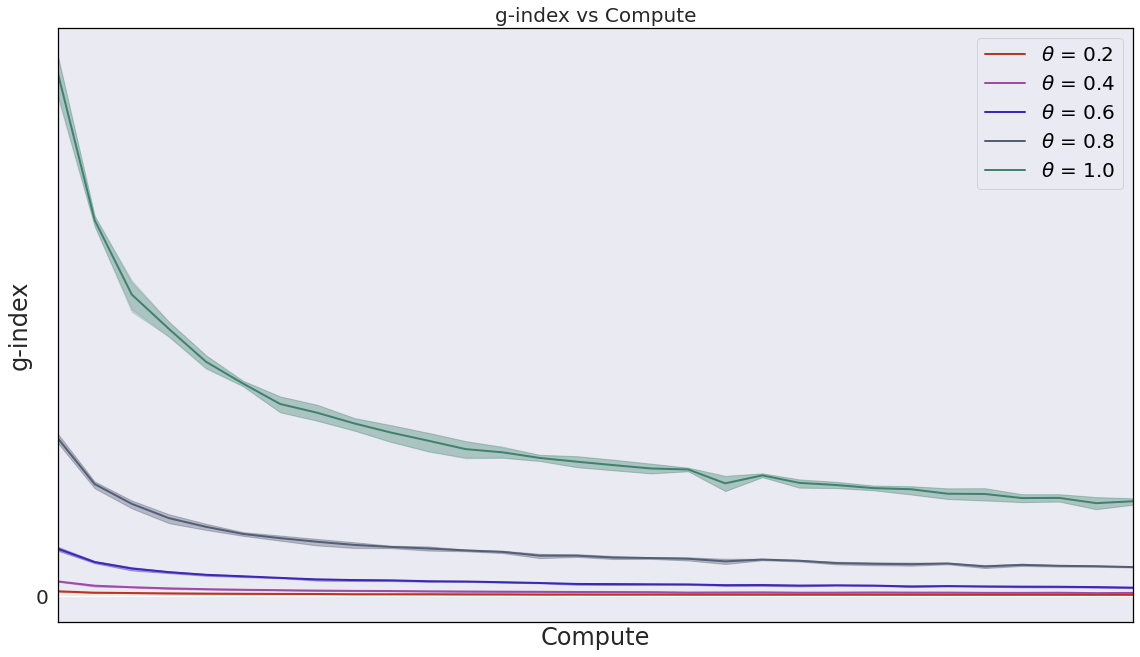

In [15]:
fig, axes = plt.subplots(figsize=FIGSIZE)
xlabel = "Compute"
ylabel = "g-index"
plt.xlim(50, 1500)
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
set_axes() # Fix axes spines & ticks, see utils.py for more details

for idx, sim_Ptheta in enumerate(results_gcp.keys()):
    vals = results_gcp.get(sim_Ptheta)
    x = vals["compute"]
    y = vals["g_index"]
    # Plot the confidence interval
    sns.lineplot(x=x, y=y, ax=axes, legend=False, linewidth=0, color=sim_colors[idx])
    #Plot the actual non-smoothed line
    sns.lineplot(x=x,y=y,ax=axes,legend=False,linewidth=2,label=f"$\\theta$ = {sim_Ptheta}",color=sim_colors[idx])

plt.legend(loc="upper right", labelcolor="black",fontsize=LEGEND_SIZE)
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=LEGEND_SIZE)
plt.show()

#### G-index vs $\theta$ ( for varying $\Omega$ ) HeatMap

<big> Setting up the following Simulation variables</big>

1. Average performance (varying)
2. Domain distance between domains (varying)
3. Number of samples per curricula domain (fixed)
4. Number of samples  per task domain (fixed)
5. Raw Experience ( compute, fixed )
6. Priors (fixed)
7. Iterations per domain (fixed) 

In [16]:
sim_PthetaValues = np.around(np.linspace(0.00, 1, 50), 2) # Average Performance Values from 0.2 to 1.0
n_curricula_domain = 40
n_tasks_domain = 5
num_domains = len(AVAILABLE_DOMAINS)
sim_E = 1e2
sim_P = 1e-2
n_iters_per_temp = 10
dd_cache = cache_dd()
sim_dd = None

In [17]:
results_gt = defaultdict(dict)

for sim_PTheta in tqdm(sim_PthetaValues):
    gi_dd = {"theta": [], "g_index": [], "domain_distance": []}
    dummy_exp = Experiment() # Setup a dummy experiment to simulate values
    for _ in range(n_iters_per_temp):
        #Randomly sample domain_distance values for every two domains from a normal distribution
        random_dd = {tA: {tB: val for tB, val in zip(AVAILABLE_DOMAINS,np.clip(np.random.normal(0.5, 0.4, 16), 0, 1).tolist())} for tA in AVAILABLE_DOMAINS}
        g_index = dummy_exp.simulate_g_index(
            n_tasks_domain=n_tasks_domain,
            n_curricula_domain=n_curricula_domain,
            sim_P=sim_P,
            sim_E=sim_E,
            sim_PTheta=sim_PTheta,
            sim_dd=random_dd,
        )
        gi_dd["theta"].append(sim_PTheta)
        gi_dd["g_index"].append(g_index)
        # get random row and just get it's domain_dist average
        gi_dd["domain_distance"].append(random_row_mean(random_dd))
    results_gt[sim_PTheta] = gi_dd

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


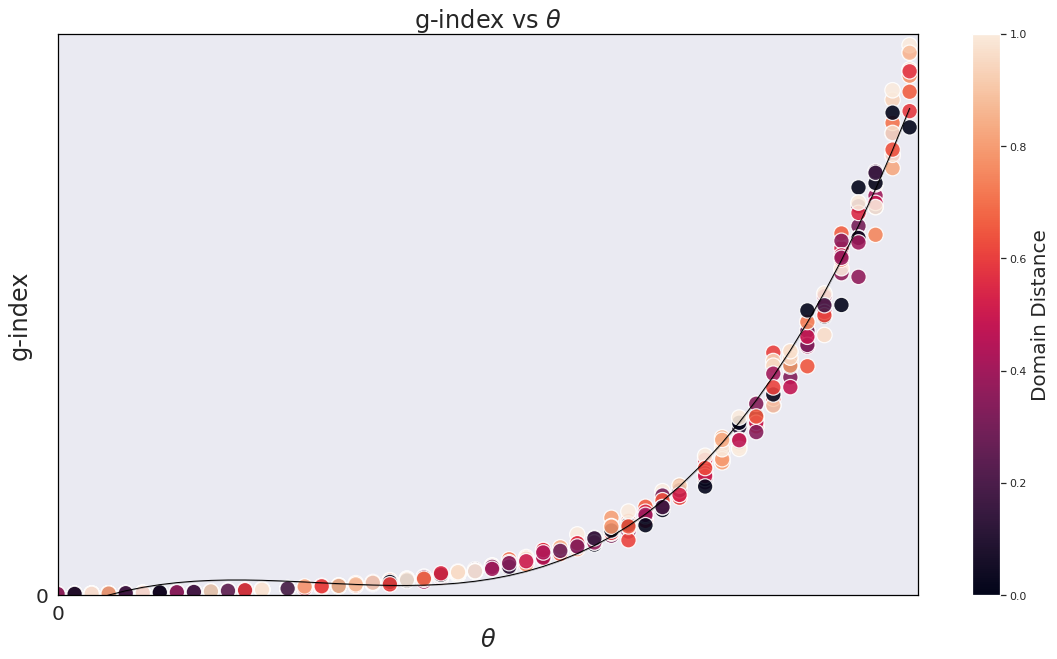

In [18]:
ylabel = "g-index"
xlabel = "$\\theta$"
fig, axes = plt.subplots(figsize=FIGSIZE)
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.xlim(0, 1.01)
plt.ylim(0, 4000)
set_axes() # Fix axes spines & ticks, see utils.py for more details

xtotal, ytotal = [], []
for sim_PTheta in results_gt.keys():
    vals = results_gt.get(sim_PTheta)
    x = vals["theta"]
    y = vals["g_index"]
    h = vals["domain_distance"]
    xtotal.extend(x)
    ytotal.extend(y)
    #Plot the points x & y 
    sns.scatterplot(x=x, y=y, hue=h, ax=axes, legend=False, s=S, alpha=ALPHA, palette="rocket")
#Gather all points x & y  & apply polynomial smoothing 
fx = np.poly1d(np.polyfit(np.array(xtotal), np.array(ytotal), 3))
z = fx(xtotal)
#Plot the smoothed line
sns.lineplot(x=xtotal, y=z, ax=axes, legend=False, linewidth=1, color="black")
# Add the colorbar for heatmap
sm = plt.cm.ScalarMappable(cmap="rocket")
axes.figure.colorbar(sm).set_label(label="Domain Distance",size=LEGEND_SIZE)

plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=TITLE_SIZE)
plt.show()

### Section-4.2 Experiment Plots

#### Average Performance ( $\theta$ )  vs Training Samples

In [19]:
results = {"IS": [], "avg_perf": [], "total_samples": [], "g_index": []}

for exp_file in EXP_FILES:
    exp = Experiment(exp_file)
    exp_c = exp.get_exp_components() # Get components of an experiment
    avg_perf = exp_c.AveragePerformance # Average Performance of an experiment 
    IS = exp_c.IS # Get the IS name of an experiment 
    CurriculaDomains = exp_c.CurriculaDomains # Get Curricula domains for an experiment 
    total_samples = sum([domain["num_samples"] for domain in CurriculaDomains]) # Total curricula samples for an experiment
    g_index = exp.calculate_g_index() # Get the g-index for an experiment 

    results["IS"].append(IS)
    results["avg_perf"].append(avg_perf)
    results["total_samples"].append(total_samples)
    results["g_index"].append(g_index)

In [20]:
gi = results["g_index"] 
g_i_dots_scales = [scale_dots(min(gi), c) for c in gi] #Calculate the scatterplot dots sizes based on g-index values
#Create a data list of (Total Samples,Avg Performance, IS name, gindex_dot_sizes)
data_list = [[x, y, model_name, marker_size] for (x, y, model_name, marker_size) in zip(results["total_samples"], results["avg_perf"], results["IS"], g_i_dots_scales)]

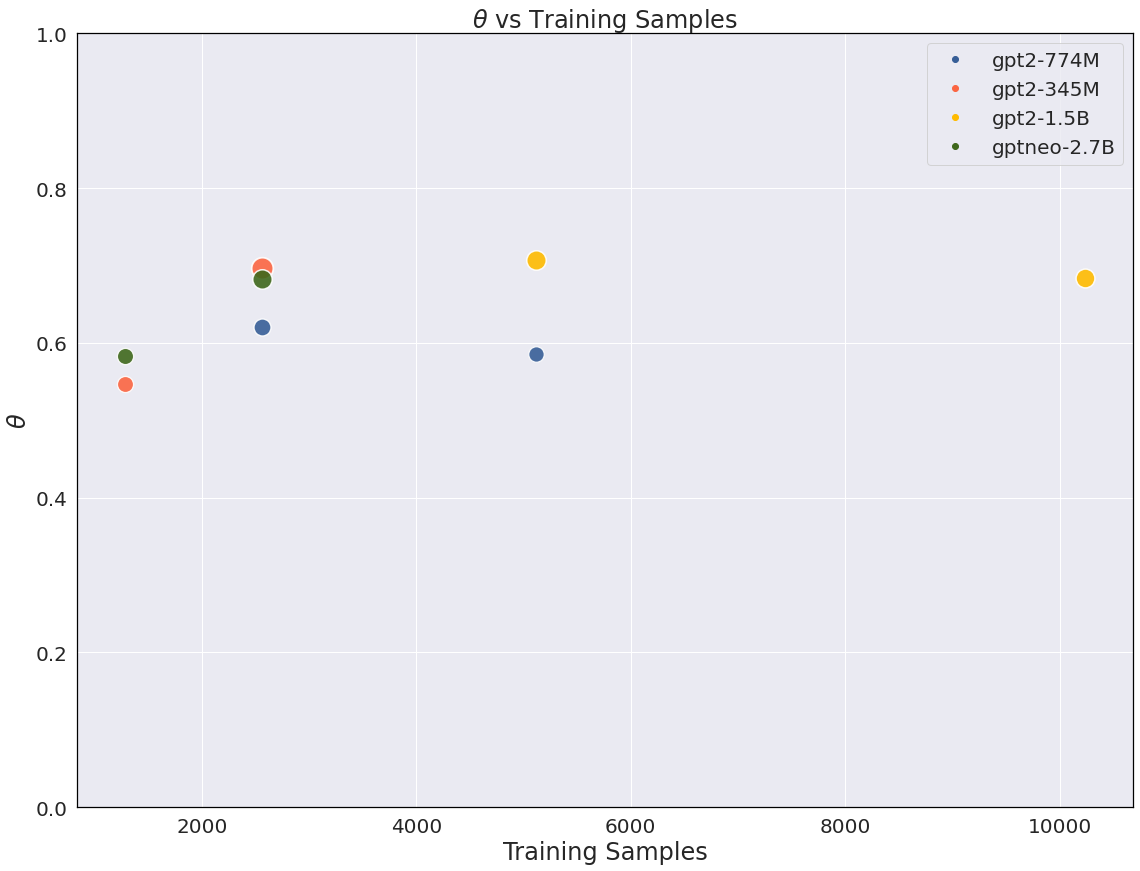

In [21]:
fig, axes = plt.subplots()
ylabel = "$\\theta$"
xlabel = "Training Samples"
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.ylim(0, 1)
set_axes(disable_ticks=False) # Fix axes spines & ticks, see utils.py for more details

color_name = "black"
axes.spines["top"].set_color(color_name)
axes.spines["bottom"].set_color(color_name)
axes.spines["left"].set_color(color_name)
axes.spines["right"].set_color(color_name)

#plot the points step by step
for entry in data_list:
    color = model_colormap[model_name_correction[entry[2]]] # Get color value for a specified model
    sns.scatterplot(x=[entry[0]], y=[entry[1]], color=color, s=entry[3], alpha=ALPHA) # plot every point on the axes

plt.tight_layout()
# Dummy plot to generate legend
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker="o", linestyle="") for color in model_colormap.values()]
plt.legend(markers, model_colormap.keys(),fontsize=LEGEND_SIZE)
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=TITLE_SIZE)
plt.show()

#### Average Domain Performance ( $\theta$ ) vs Program Size

In [22]:
domains_considered = AVAILABLE_DOMAINS
results_pst = {"IS": [], "domain_name": [], "program_size": [], "theta": []}

for exp_file in EXP_FILES:
    exp = Experiment(exp_file) # Setup a dummy experiment to simulate values
    for domain in domains_considered:
        exp_c = exp.get_exp_components() # Get components of an experiment
        IS = exp_c.IS # Get the IS name of an experiment 
        perf_details = exp_c.PerformanceDetails # Per domain performance of an experiment 
        perf_details = next(item for item in perf_details if item["name"] == domain)
        program_size = DOMAIN_LENGTHS[domain]

        exp_c = exp.get_exp_components() # Get components of an experiment
        results_pst["IS"].append(IS)
        results_pst["domain_name"].append(domain)
        results_pst["program_size"].append(program_size)
        results_pst["theta"].append(perf_details["performance"])
df = pd.DataFrame(results_pst).groupby(by=["domain_name", "IS"]).mean()

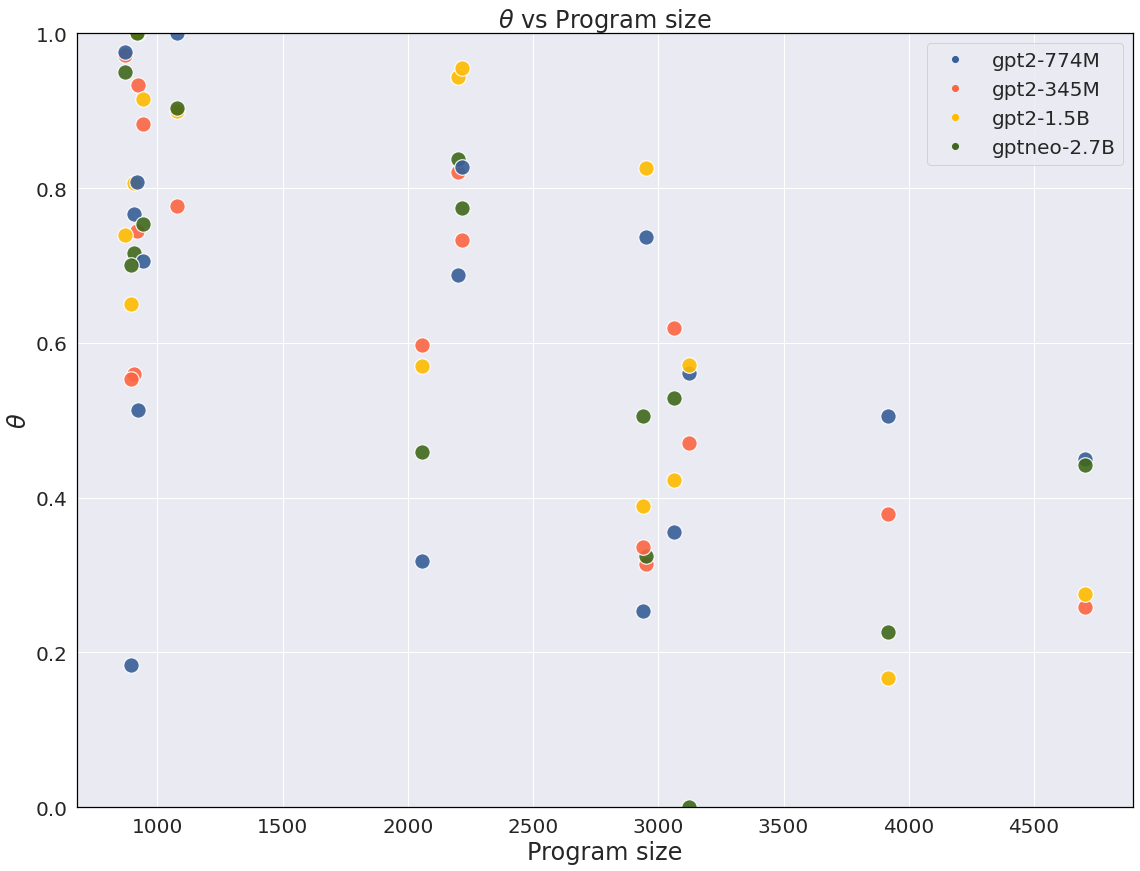

In [23]:
fig, axes = plt.subplots()
xlabel = "Program size"
ylabel = "$\\theta$"
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.ylim(0, 1)
set_axes(disable_ticks=False) # Fix axes spines & ticks, see utils.py for more details

for temp in domains_considered:
    tdf = df.loc[temp] 
    tdf = tdf.reindex(list(model_name_correction.keys()))
    x = tdf["program_size"]
    y = tdf["theta"]
    for model in model_name_correction.keys():
        x = tdf.loc[model]["program_size"]
        y = tdf.loc[model]["theta"]
        color = model_colormap[model_name_correction[model]]
        sns.scatterplot(x=[x], y=[y], color=color, s=S, alpha=ALPHA) 

plt.tight_layout()
# Dummy Plot to Generate Legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color, marker="o", linestyle="")
    for color in model_colormap.values()
]
plt.legend(markers, model_colormap.keys(),fontsize=LEGEND_SIZE)
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=TITLE_SIZE)
plt.show()

#### Skill level vs Program Size 

In [24]:
results_def = {"IS": [], "domain_name": [], "program_size": [], "skill_level": []}
for exp_file in EXP_FILES:
    exp = Experiment(exp_file)
    for domain in domains_considered:
        exp_c = exp.get_exp_components() # Get components of an experiment
        IS = exp_c.IS # Get the IS name of an experiment 
        perf_details = exp_c.PerformanceDetails # Per domain performance of an experiment 
        
        perf_details = next(item for item in perf_details if item["name"] == domain)
        program_size = DOMAIN_LENGTHS[domain]
        results_def["IS"].append(IS)
        results_def["domain_name"].append(domain)
        results_def["program_size"].append(program_size)
        results_def["skill_level"].append(perf_details["perfects"])
df = pd.DataFrame(results_def).groupby(by=["domain_name", "IS"]).mean()

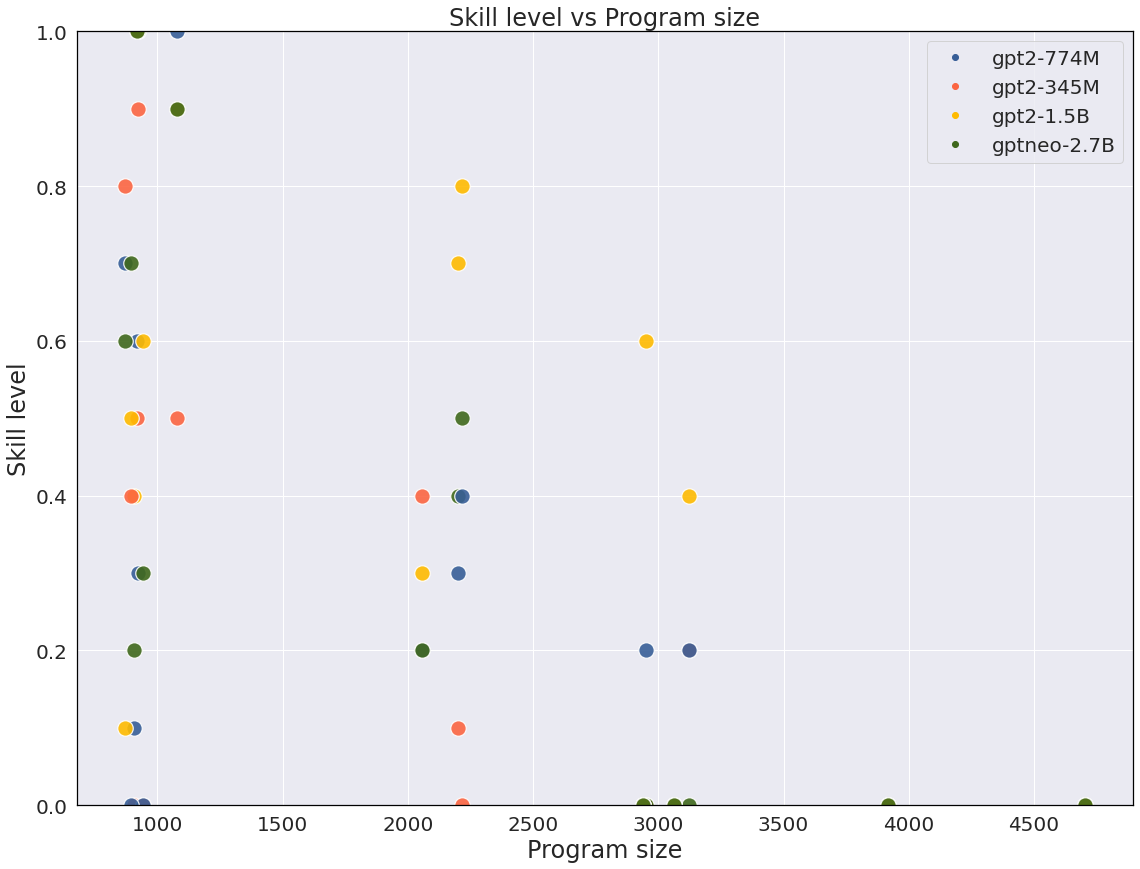

In [25]:
fig, axes = plt.subplots()
xlabel = "Program size"
ylabel = "Skill level"
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.ylim(0, 1)
set_axes(disable_ticks=False) # Fix axes spines & ticks, see utils.py for more details

#plotting the points domain-wise
for domain in domains_considered:
    tdf = df.loc[domain] #temporary_df for the domain
    tdf = tdf.reindex(model_name_correction.keys()) #reindex by model names
    x = tdf["program_size"]
    y = tdf["skill_level"]
    for model in model_name_correction.keys(): #plot individual points per domain
        x = tdf.loc[model]["program_size"]
        y = tdf.loc[model]["skill_level"]
        color = model_colormap[model_name_correction[model]] # get the color for a model.
        sns.scatterplot(x=[x], y=[y], color=color, s=S, alpha=ALPHA)

plt.tight_layout()
# Dummy Plot to Generate Legend
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker="o", linestyle="") for color in model_colormap.values()]
plt.legend(markers, model_colormap.keys(),fontsize=LEGEND_SIZE)
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=TITLE_SIZE)
plt.show()

#### Compute Vs Average Performance ( $\theta$ ) 

In [26]:
results_ct = {"IS": [], "avg_perf": [], "compute": [], "g_index": []}
for exp_file in EXP_FILES:
    exp = Experiment(exp_file)
    exp_c = exp.get_exp_components(return_raw_experience=True) # Get components of an experiment with raw compute
    IS = exp_c.IS # Get the IS name of an experiment 
    avg_perf = exp_c.AveragePerformance # Average Performance of an experiment 
    compute = exp_c.E # Get compute for an experiment
    g_index = exp.calculate_g_index() #Calculate g-index for the experiment
    results_ct["IS"].append(model_name_correction[IS])
    results_ct["avg_perf"].append(avg_perf)
    results_ct["compute"].append(compute)
    results_ct["g_index"].append(g_index)

In [27]:
g_i_dots_scales = [scale_dots(min(gi), c) for c in results_ct["g_index"]]#Calculate the scatterplot dots sizes based on g-index values
#Create a data list of (Total Samples,Avg Performance, IS name, gindex_dot_sizes)
data_list = [[x,y,marker_size,model_name] for (x,y,marker_size,model_name) in zip(results_ct["compute"], results_ct["avg_perf"], g_i_dots_scales, results_ct["IS"])]

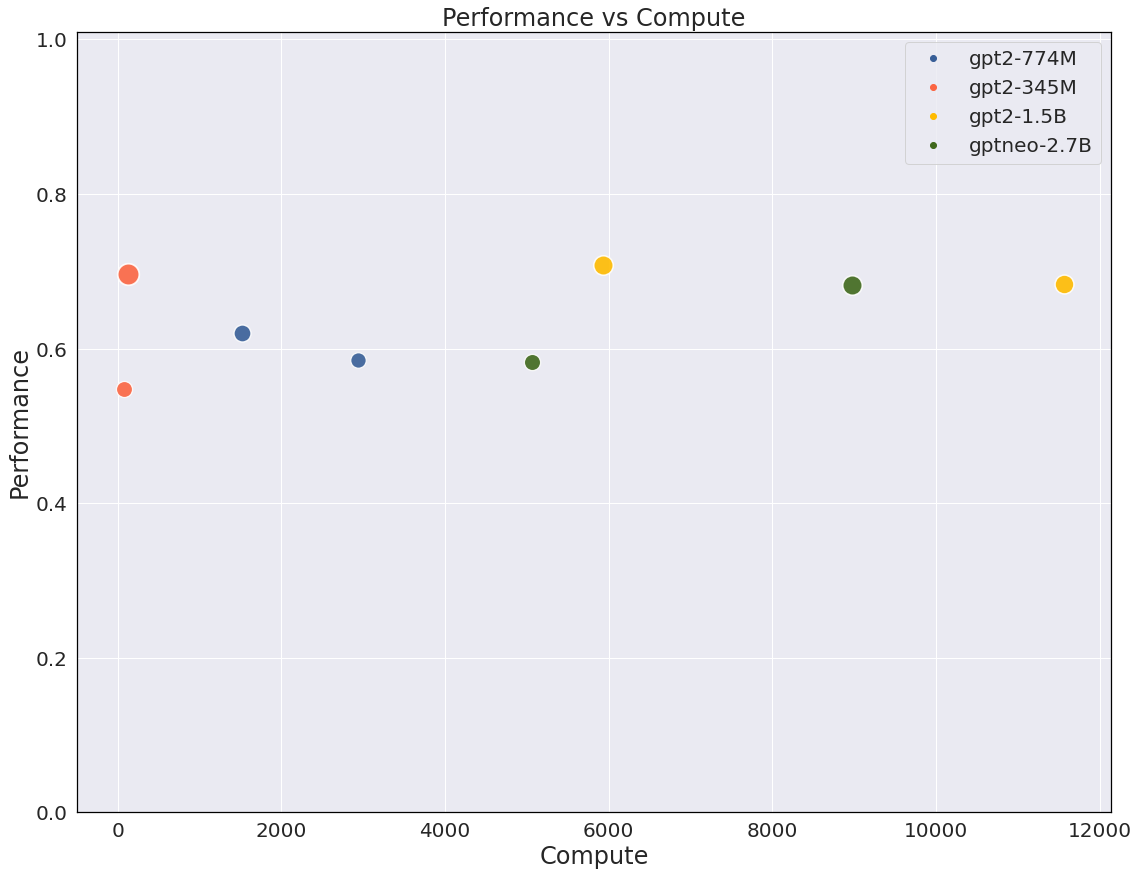

In [28]:
fig, axes = plt.subplots()
ylabel = "Performance"
xlabel = "Compute"
plt.xlabel(xlabel, fontsize=LABEL_SIZE)
plt.ylabel(ylabel, fontsize=LABEL_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
axes.tick_params(labelsize=TICK_SIZE)
plt.ylim(0, 1.01)
set_axes(disable_ticks=False) # Fix axes spines & ticks, see utils.py for more details

#plot the points step by step
for entry in data_list:
    sns.scatterplot(x=[entry[0]],y=[entry[1]],color=model_colormap[entry[3]],s=entry[2],alpha=ALPHA) # plot every point on the axes
    
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker="o", linestyle="") for color in model_colormap.values()]
plt.legend(markers, model_colormap.keys(),fontsize=LEGEND_SIZE)
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}", loc="center",fontsize=TITLE_SIZE)
plt.show()

## 5. Request the data

Please send us a mail at the [humans@mayahq.com](mailto:humans@mayahq.com) with the following details to get the data.<br>
Email Subject: `g-index data request`

```markdown
Name:
I/We are an : [Individual/Organisation]
Our use case : [Brief Description]
```

## 6. Cite us!

If this repository, the paper or any of its content is useful for your research, please cite:

```
@misc{venkatasubramanian2021measure,
      title={Towards A Measure Of General Machine Intelligence}, 
      author={Gautham Venkatasubramanian and Sibesh Kar and Abhimanyu Singh and Shubham Mishra and Dushyant Yadav and Shreyansh Chandak},
      year={2021},
      eprint={2109.12075},
      archivePrefix={arXiv},
      primaryClass={cs.AI}
}
```